<a href="https://colab.research.google.com/github/tassiLuca/dia-project/blob/master/fetal_health_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetal Health Classification
## Progetto d'Esame di _Applicazioni di Data Intensive_
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

**Luca Tassinari** • **luca.tassinari10@studio.unibo.it**

In [222]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [223]:
import os
from urllib.request import urlretrieve
def download(file, url):
    ''' A simple function to download, from a given url, a file. '''
    if not os.path.isfile(file):
        urlretrieve(url, file)

## Introduzione al caso di studio
### Contesto
La riduzione della mortalità infatile è uno degli [obiettivi](https://www.eda.admin.ch/agenda2030/it/home/agenda-2030/die-17-ziele-fuer-eine-nachhaltige-entwicklung/ziel-3--ein-gesundes-leben-fuer-alle-menschen-jeden-alters-gewae.html) di sviluppo sostenibile delle Nazioni Unite e, sicuramente, uno dei grandi indicatori del progresso Umano.

Oltre alla mortalità infantile bisogna considerare anche la mortalità materna, che si verifica maggiormente nei contesti con basse risorse.

In questo contesto, la cardiotocografia è un esame poco invasivo che viene effettuato durante il periodo prenatale e che, grazie a un trasduttore a ultrasuoni, permette di monitorare la frequenza cardiaca fetale (FHR), i movimenti fetali, le contrazioni uterine e altro ancora.

### I dati
Lo scopo è riuscire a creare un algoritmo di **classificazione** che permetta di identificare i bimbi a rischio e quelli in condizioni patologiche.
Per farlo si usa un dataset scaricato da [kaggle](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification) in cui 2126 registrazioni delle caratteristiche estratte dalle cardiotocografie sono state classificate da tre ostetriti esperti in 3 classi:
- Normale
- Sospetto
- Patologico

In [224]:
download("data.csv.gz", "https://github.com/tassiLuca/dia-project/raw/master/datasets/fetal_health.csv.gz")

In [225]:
data = pd.read_csv(
    "data.csv.gz", 
    compression="gzip"
)

In [226]:
# by default pandas uses only 20 cols
pd.options.display.max_columns = len(data.columns)

In [227]:
data

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,7.2,40.0,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,7.1,66.0,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,6.1,67.0,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


Descriviamo qui brevemente le 22 _feature_ del dataset:
- `baseline value` (numerica): Frequenza cardiaca fetale
- `accelerations` (numerica): Numero di accellerazioni per secondo
- `fetal_movement` (numerica): Numero di movimenti fetali per secondo
- `uterine_contractions` (numerica): Numero di contazioni uterine per secondo
- `light_decelerations` (numerica): Numero di LD al secondo
- `severe_decelerations` (numerica): Numero di SD al secondo
- `prolongued_decelerations`: Number of PDs per second
- `abnormal_short_term_variability`: Percentage of time with abnormal short term variability
- `mean_value_of_short_term_variability`: Mean value of short term variability
- `percentage_of_time_with_abnormal_long_term_variability`: Percentage of time with abnormal long term variability
- `mean_value_of_long_term_variability`: Mean value of long term variability
- `histogram_width`: Width of the histogram made using all values from a record
- `histogram_min`: Histogram minimum value
- `histogram_max`: Histogram maximum value
- `histogram_number_of_peaks`: Number of peaks in the exam histogram
- `histogram_number_of_zeroes`: Number of zeroes in the exam histogram
- `histogram_mode`: Hist mode
- `histogram_mean`: Hist mean
- `histogram_median`: Hist median
- `histogram_variance`: Hist variance
- `histogram_tendency`: Histogram trend
- **`fetal_health`: da predire**
    - 0: normale
    - 1: sospetto
    - 2: patologico

## Analisi esplorativa dei dati

Definiamo un dizionario per mappare le classi in una descrizione più leggibile:

In [228]:
diagnosis_desc = {1.0: "normale", 2.0: "sospetto", 3.0: "patologico"}

In [229]:
diagnosis_color_map = {1.0: "green", 2.0: "orange", 3.0: "red"}

In [230]:
diagnosis_colors = data["fetal_health"].map(diagnosis_color_map)

Visualizziamo la distribuzione dei dati nel dataset, attraverso un semplice grafico a torta.

Come si può osservare il 78% delle osservazioni del dataset sono state classificate come normali, il 14% come sospetto e circa l'8% delle osservazioni come casi patologici.

In [231]:
dd = data["fetal_health"].map(diagnosis_desc).value_counts().to_frame(name="count")
dd["%"] = (dd["count"] / len(data)) * 100
dd

,count,%
normale,1655,77.845720
sospetto,295,13.875823
patologico,176,8.278457


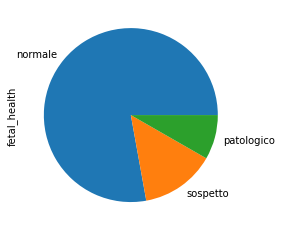

In [232]:

data["fetal_health"].map(diagnosis_desc).value_counts().plot.pie()

In [233]:
data.iloc[:, :-1].describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000


In [234]:
range(len(data.columns[:-1]))

range(0, 21)

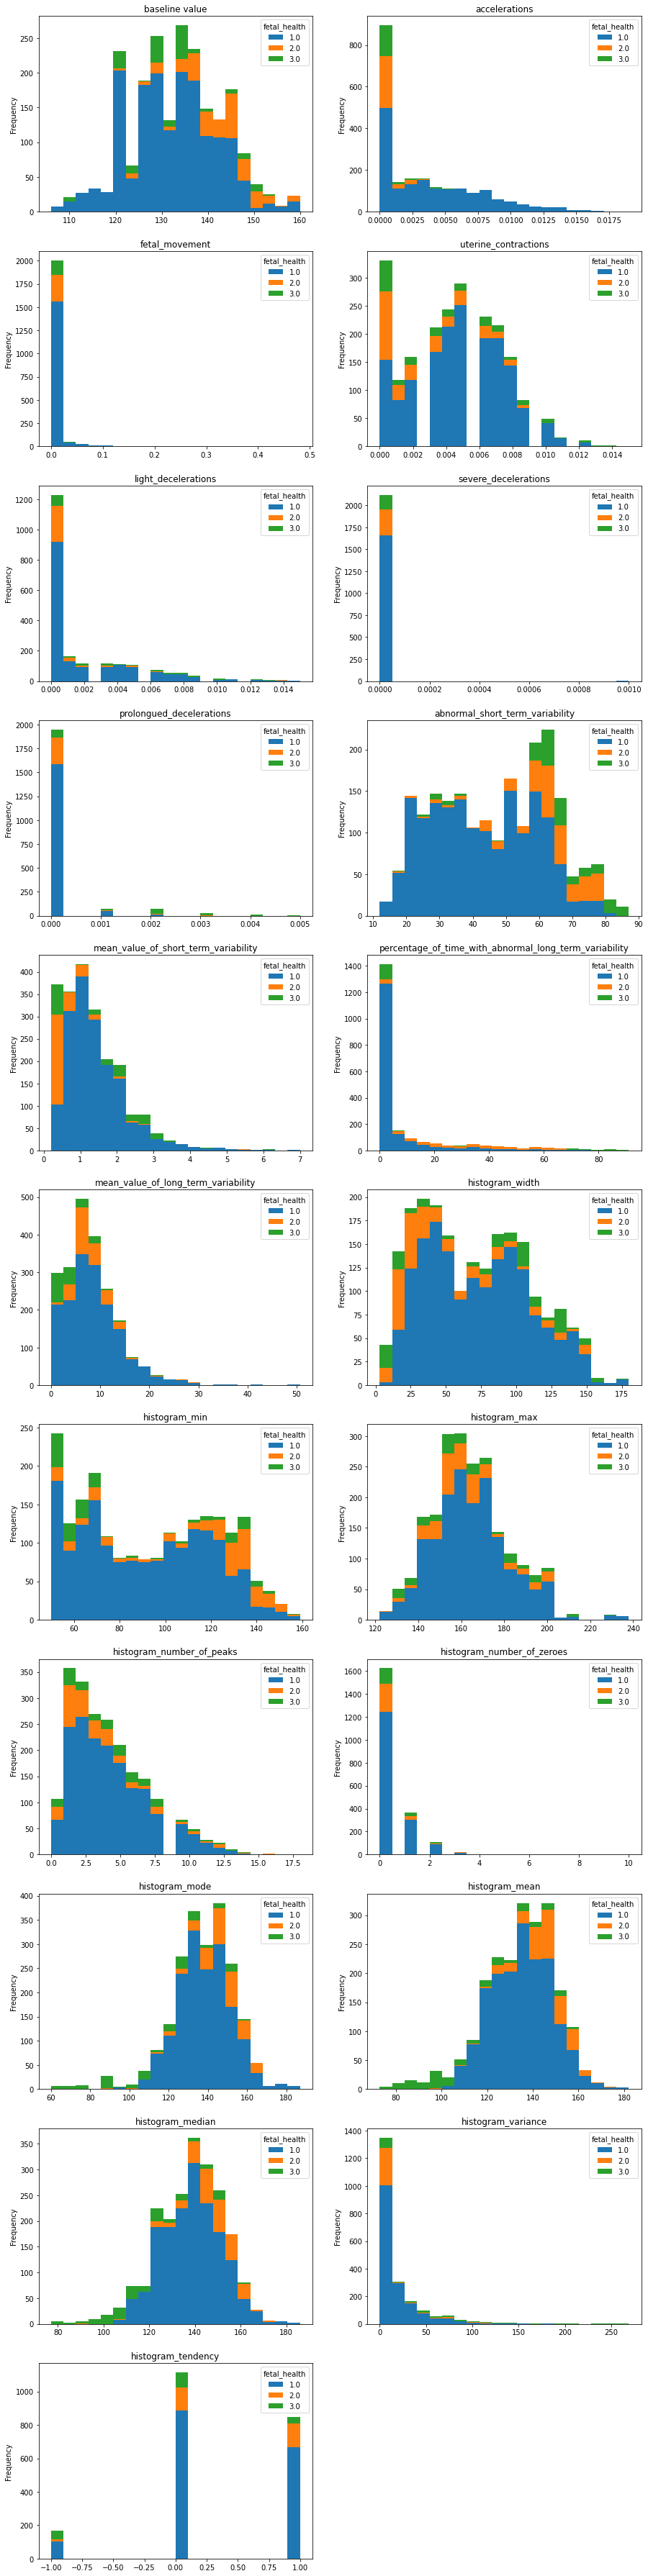

In [235]:
plt.figure(figsize=(15, 65))
for col, i in zip(data.columns[:-1], range(len(data.columns[:-1]))):
    data.pivot(columns="fetal_health")[col].plot.hist(
        bins=20, 
        stacked=True, 
        title=col, 
        ax=plt.subplot(11, 2, i+1)
    )

Appare evidente una relazione tra la variabile target e le feature:
- `abnormal_short_tem_variability`
...

Calcoliamo la correlazione con il metodo Pearson

In [236]:
data_corr = data.corr(method='pearson')

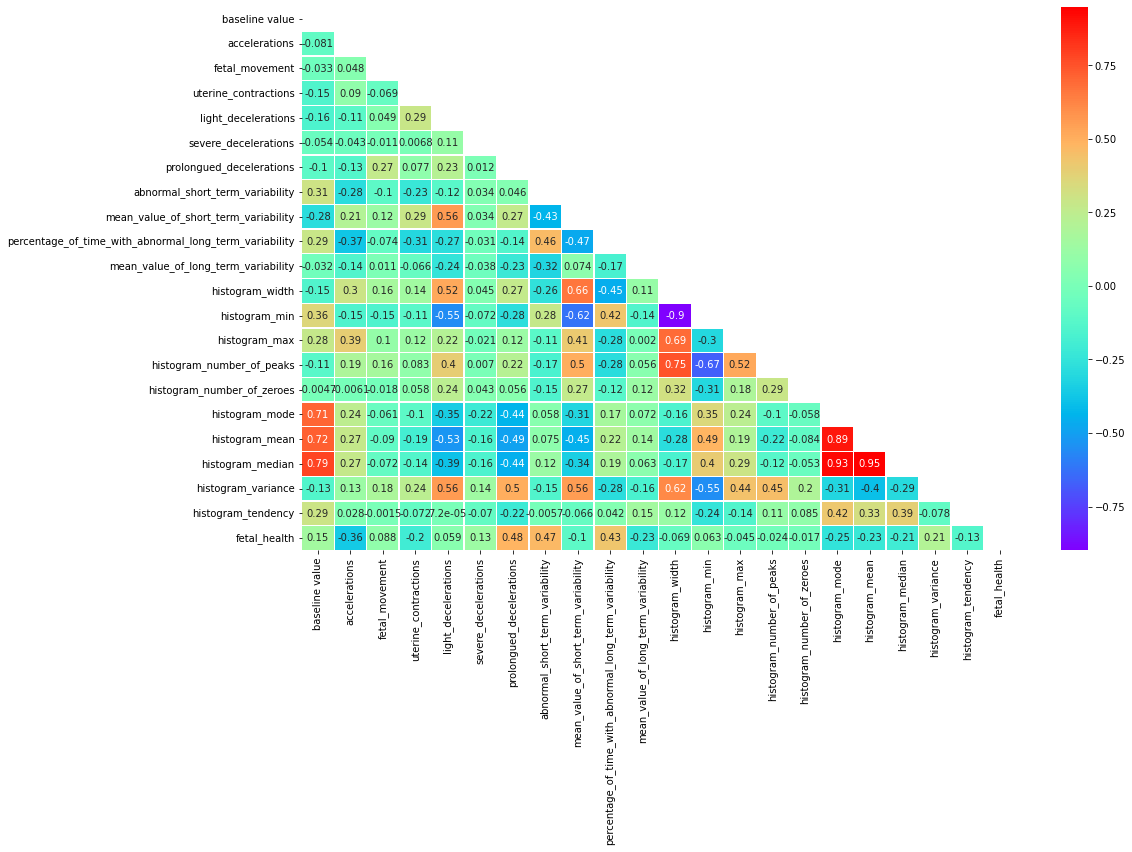

In [237]:
mask = np.zeros_like(data_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(16, 10))
sns.heatmap(data_corr, mask=mask, cmap="rainbow", linewidths=0.30, annot=True)

Come si può vedere vi è correlazione tra `prolungued_decelerations`, `abnormal_short_term_variability`, `percentage_of_time_with_abnormal_long_term_variability`.

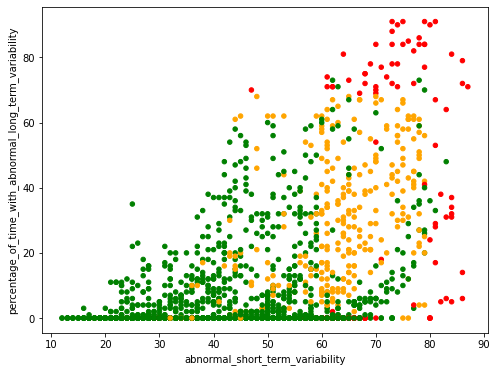

In [238]:
data.plot.scatter(
    "abnormal_short_term_variability", 
    "percentage_of_time_with_abnormal_long_term_variability", 
    c=diagnosis_colors, 
    figsize=(8, 6)
);

## CLASSIFICAZIONE LINEARE

In [239]:
from sklearn.metrics import confusion_matrix, f1_score
def print_eval(X_val, y_val, model):
    '''
    Function to print prediction accuracy stats.
    '''
    print(f"Score: {model.score(X_val, y_val):3.3f} \
        ({model.score(X_val, y_val)*100:5.2f}%)")
    cf = pd.DataFrame(
        confusion_matrix(y_val, model.predict(X_val)), 
        index=model.classes_, 
        columns=model.classes_
    )
    print("\nConfusion Matrix: ")
    print(cf)
    score_f1 = f1_score(y_val, model.predict(X_val), average=None)
    print("\nf1_score per feature: ")
    print(score_f1)
    score_f1_agg = f1_score(y_val, model.predict(X_val), average="macro")
    print(f"\nf1_score macro: {score_f1_agg:3.3f}")

Suddivido in training e validation set i dati.

In [240]:
X = data.drop(["fetal_health"], axis=1)
y = data["fetal_health"]

In [241]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,               # dati da suddividere
    test_size = 1/3,    # proporzione: 2/3 training set, 1/3 validation set
    random_state = 42   # seed per la riproducibilità
)

In [242]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

def get_tuned_model(model, params_grid, X_train, y_train):
    '''
    Create a stratified k fold and find the best params with grid search
    '''
    skf = StratifiedKFold(5, shuffle=True)
    gs = GridSearchCV(model, params_grid, cv=skf)
    gs.fit(X_train, y_train)
    ranking = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)
    return gs, gs.best_params_, ranking

In [243]:
def get_features_scores(model):
    fs = pd.DataFrame(
        model.best_estimator_[-1].coef_.T,
        columns=["Normal", "Suspect", "Pathological"], 
        index=X.columns
    )
    fs.plot.bar(figsize=(15,8), grid=True, stacked=True, width=.8)
    return fs

2 approcci:
- con `multi_class="ovr"` (_one versus rest_) per ciascuna classe C si addestra un modello indipendentemente dagli altri a distinguere "C" da "non C"
- con `multi_class="multinomial"` (default) viene calcolata e minimizzata un'unica funzione d'errore (con eventuale regolarizzazione) su tutti gli iperpiani

### Capire il signficato della classificazione... caso di studio con 2 feature

In [244]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [245]:
X_2f = data[[data.columns[7], data.columns[9]]]
y_2f = data["fetal_health"]

In [246]:
from sklearn.model_selection import train_test_split
X2f_train, X2f_val, y2f_train, y2f_val = train_test_split(
    X_2f, y_2f,         # dati da suddividere
    test_size = 1/3,    # proporzione: 2/3 training set, 1/3 validation set
    random_state = 42   # seed per la riproducibilità
)

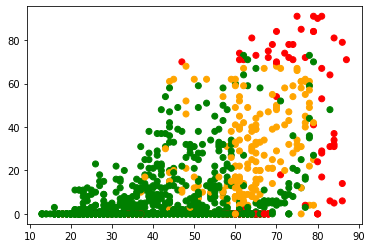

In [247]:
plt.scatter(*X2f_train.values.T, c=y2f_train.map(diagnosis_color_map))

In [248]:
y2f_train.shape

(1417,)

In [249]:
params_grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["none"],
        "lr__multi_class": ["ovr", "multinomial"]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2", "l1"],
        "lr__C": np.logspace(-3, 3, 7),
        "lr__multi_class": ["ovr", "multinomial"]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["elasticnet"],
        "lr__C": np.logspace(-3, 3, 7),
        "lr__l1_ratio": [.0, 0.2, 0.4, 0.6, 0.8, 1.],
        "lr__multi_class": ["ovr", "multinomial"]
    }
]

In [250]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver="saga"))
])
m, m_best_params, m_ranking = \
    get_tuned_model(model, params_grid, X2f_train, y2f_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

In [251]:
m.best_estimator_[-1].coef_

array([[-0.94179611, -0.39591017],
       [ 0.20347308,  0.33117688],
       [ 0.73832303,  0.06473329]])

In [252]:
m.best_estimator_[-1].intercept_

array([ 1.70221702, -0.52488115, -1.17733588])

In [253]:
def separator_2d(model, x1, n=0):
    return -x1 * model.best_estimator_[-1].coef_[n, 0] - \
        model.best_estimator_[-1].intercept_[n] / model.best_estimator_[-1].coef_[n, 1]

In [254]:
X2f_train

,abnormal_short_term_variability,percentage_of_time_with_abnormal_long_term_variability
1567,24.0,0.0
2120,77.0,17.0
1182,29.0,0.0
1173,23.0,0.0
1047,33.0,2.0
...,...,...
1638,52.0,0.0
1095,22.0,0.0
1130,20.0,0.0
1294,24.0,0.0


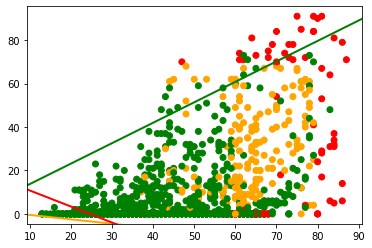

In [255]:
plt.scatter(*X2f_train.values.T, c=y2f_train.map(diagnosis_color_map))
xlim, ylim = plt.xlim(), plt.ylim()
for n, c in enumerate(m.classes_):
    sep_x = np.linspace(*xlim, 2)
    sep_y = separator_2d(m, sep_x, n)
    plt.plot(sep_x, sep_y, c=diagnosis_color_map[c], linewidth=2)
plt.xlim(xlim); plt.ylim(ylim);

### Perceptron

In [256]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

**NOTA: Percepetron usa la versione ONE-VERSUS-ALL**. 
Vedi [qui](https://scikit-learn.org/stable/modules/multiclass.html)

Grid search per ottenere i parametri migliori:
- `penalty` (default=`None`): The penalty (aka regularization term) to be used => {‘l2’,’l1’,’elasticnet’}
- `alpha` (default=`0.0001`): Constant that multiplies the regularization term if regularization is used (lambda term in the Moro slides)
- `l1_ratio` (default=`0.15`): The Elastic Net mixing parameter, with `0 <= l1_ratio <= 1`. `l1_ratio=0` corresponds to L2 penalty, `l1_ratio=1` to L1. **Only used if penalty='elasticnet'**.



In [257]:
params_grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["none"],
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2", "l1"],
        "lr__alpha": np.logspace(-2, 2, 5),
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["elasticnet"],
        "lr__alpha": np.logspace(-2, 3, 6),
        "lr__l1_ratio": [0.2, 0.4, 0.6, 0.8],
    }
]

In [258]:
perceptron_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", Perceptron())
])
perceptron, perceptron_best_params, perceptron_ranking = \
    get_tuned_model(perceptron_model, params_grid, X_train, y_train)

I migliori parametri ottenuti sono:

In [259]:
perceptron_best_params

{'lr__penalty': 'none', 'scaler': StandardScaler()}

Le prime 5 combinazioni di parametri che danno miglior score:

In [260]:
perceptron_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__penalty,param_scaler,param_lr__alpha,param_lr__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.009997,0.001042,0.002124,0.000110,none,StandardScaler(),NaN,NaN,"{'lr__penalty': 'none', 'scaler': StandardScal...",0.859155,0.890845,0.893993,0.879859,0.840989,0.872968,0.020112,1
27,0.014882,0.001358,0.002597,0.000051,elasticnet,StandardScaler(),0.01,0.6,"{'lr__alpha': 0.01, 'lr__l1_ratio': 0.6, 'lr__...",0.848592,0.894366,0.862191,0.826855,0.830389,0.852478,0.024530,2
23,0.015032,0.001473,0.002610,0.000073,elasticnet,StandardScaler(),0.01,0.2,"{'lr__alpha': 0.01, 'lr__l1_ratio': 0.2, 'lr__...",0.813380,0.890845,0.826855,0.837456,0.812721,0.836251,0.028799,3
29,0.013280,0.000658,0.002660,0.000229,elasticnet,StandardScaler(),0.01,0.8,"{'lr__alpha': 0.01, 'lr__l1_ratio': 0.8, 'lr__...",0.823944,0.859155,0.816254,0.869258,0.809187,0.835560,0.024064,4
25,0.016113,0.002194,0.002740,0.000304,elasticnet,StandardScaler(),0.01,0.4,"{'lr__alpha': 0.01, 'lr__l1_ratio': 0.4, 'lr__...",0.869718,0.823944,0.826855,0.837456,0.816254,0.834845,0.018715,5


,Normal,Suspect,Pathological
baseline value,-2.970235,-8.724449,22.207630
accelerations,25.898573,-26.216123,-10.767121
fetal_movement,-3.159419,-3.044333,0.558166
uterine_contractions,12.249988,-4.200433,-7.073294
light_decelerations,3.349595,2.291009,-1.355019
severe_decelerations,-2.021500,-13.704903,4.695097
prolongued_decelerations,-14.909222,5.518789,10.100234
abnormal_short_term_variability,-11.119334,7.882511,16.656710
mean_value_of_short_term_variability,6.559647,2.044763,-11.030729
percentage_of_time_with_abnormal_long_term_variability,-1.227628,1.278332,7.382091


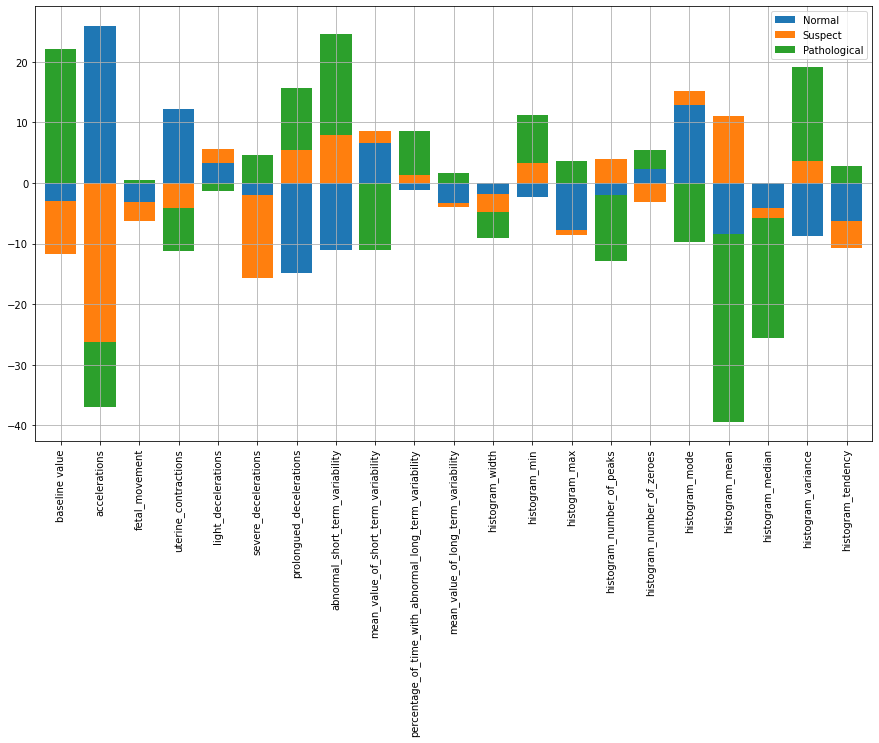

In [261]:
get_features_scores(perceptron)

In [262]:
print_eval(X_val, y_val, perceptron)

Score: 0.883         (88.29%)

Confusion Matrix: 
     1.0  2.0  3.0
1.0  515   37    8
2.0   21   75    8
3.0    1    8   36

f1_score per feature: 
[0.93892434 0.66964286 0.74226804]

f1_score macro: 0.784


### Modello multi-layer perceptron 

In [316]:
from sklearn.neural_network import MLPClassifier

In [317]:
multi_layer_perceptron_model = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(activation="relu"))
])

In [318]:
params_grid = {
    "mlp__hidden_layer_sizes": [16, 32, (16, 8)],
    "mlp__batch_size": [100, 200]
}

In [320]:
multi_layer, multi_layer_best_params, multi_layer_ranking = \
    get_tuned_model(multi_layer_perceptron_model, params_grid, X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

In [321]:
multi_layer_best_params

{'mlp__batch_size': 100, 'mlp__hidden_layer_sizes': 32}

In [324]:
print_eval(X_val, y_val, multi_layer)

Score: 0.920         (91.96%)

Confusion Matrix: 
     1.0  2.0  3.0
1.0  534   23    3
2.0   17   80    7
3.0    4    3   38

f1_score per feature: 
[0.95784753 0.76190476 0.8172043 ]

f1_score macro: 0.846


### Logistic Regression

In [263]:
from sklearn.linear_model import LogisticRegression

In [264]:
params_grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["none"],
        "lr__multi_class": ["ovr", "multinomial"]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2", "l1"],
        "lr__C": np.logspace(-3, 3, 7),
        "lr__multi_class": ["ovr", "multinomial"]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["elasticnet"],
        "lr__C": np.logspace(-3, 3, 7),
        "lr__l1_ratio": [.0, 0.2, 0.4, 0.6, 0.8, 1.],
        "lr__multi_class": ["ovr", "multinomial"]
    }
]

In [265]:
logistic_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver="saga"))
])

In [266]:
%%capture --no-display
logistic, logistic_best_params, logistic_ranking = \
    get_tuned_model(logistic_model, params_grid, X_train, y_train)

In [267]:
logistic_best_params

{'lr__C': 0.1,
 'lr__multi_class': 'multinomial',
 'lr__penalty': 'l2',
 'scaler': StandardScaler()}

In [268]:
logistic_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__multi_class,param_lr__penalty,param_scaler,param_lr__C,param_lr__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
111,0.082784,0.002513,0.002533,0.000488,multinomial,elasticnet,StandardScaler(),0.1,0.0,"{'lr__C': 0.1, 'lr__l1_ratio': 0.0, 'lr__multi...",0.908451,0.880282,0.908127,0.904594,0.862191,0.892729,0.018507,1
25,0.079701,0.001219,0.002334,0.000071,multinomial,l2,StandardScaler(),0.1,NaN,"{'lr__C': 0.1, 'lr__multi_class': 'multinomial...",0.908451,0.880282,0.908127,0.904594,0.862191,0.892729,0.018507,1
115,0.105867,0.002245,0.002696,0.000028,multinomial,elasticnet,StandardScaler(),0.1,0.2,"{'lr__C': 0.1, 'lr__l1_ratio': 0.2, 'lr__multi...",0.908451,0.880282,0.911661,0.901060,0.862191,0.892729,0.018775,1
43,0.162975,0.038935,0.003022,0.000606,multinomial,l1,StandardScaler(),10.0,NaN,"{'lr__C': 10.0, 'lr__multi_class': 'multinomia...",0.915493,0.866197,0.883392,0.932862,0.862191,0.892027,0.027749,4
223,0.107951,0.003143,0.002537,0.000214,multinomial,elasticnet,StandardScaler(),1000.0,0.8,"{'lr__C': 1000.0, 'lr__l1_ratio': 0.8, 'lr__mu...",0.915493,0.862676,0.883392,0.932862,0.862191,0.891323,0.028432,5


,Normal,Suspect,Pathological
baseline value,-0.326249,-0.250048,0.576297
accelerations,1.110231,-0.869125,-0.241106
fetal_movement,-0.253586,0.050197,0.203389
uterine_contractions,0.419614,-0.178788,-0.240826
light_decelerations,0.033873,-0.164425,0.130552
severe_decelerations,-0.010849,-0.058429,0.069278
prolongued_decelerations,-0.647979,0.169114,0.478865
abnormal_short_term_variability,-0.920290,0.125367,0.794923
mean_value_of_short_term_variability,0.205006,-0.068771,-0.136236
percentage_of_time_with_abnormal_long_term_variability,-0.416215,-0.051657,0.467871


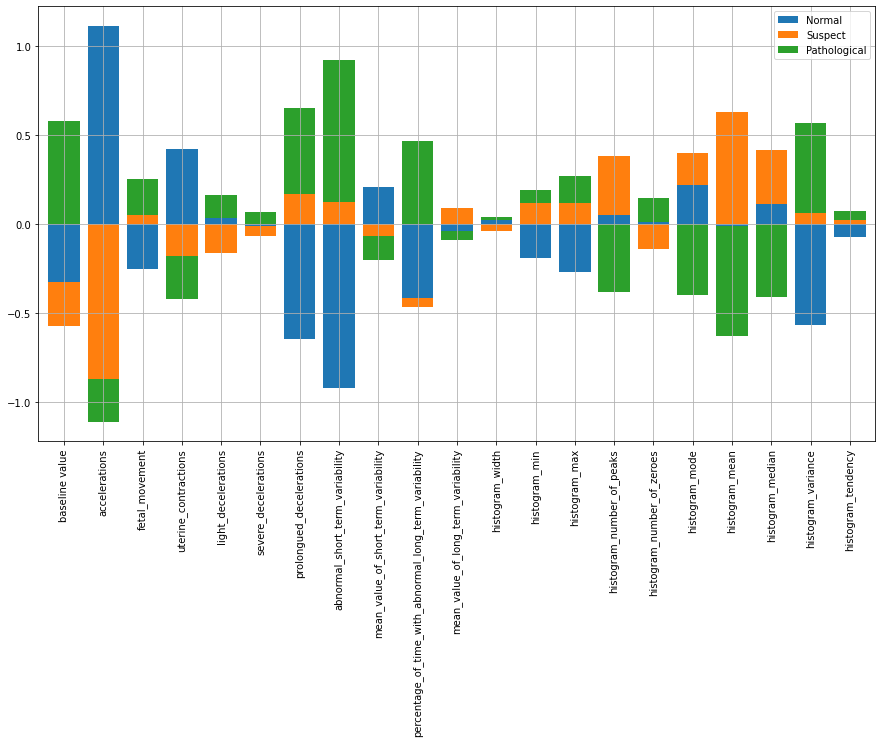

In [269]:
get_features_scores(logistic)

In [270]:
print_eval(X_val, y_val, logistic)

Score: 0.900         (89.99%)

Confusion Matrix: 
     1.0  2.0  3.0
1.0  533   22    5
2.0   29   68    7
3.0    4    4   37

f1_score per feature: 
[0.94671403 0.68686869 0.78723404]

f1_score macro: 0.807


### SVM

In [279]:
from sklearn.svm import LinearSVC

In accordo con la documentazione: 
> **multi_class{‘ovr’, ‘crammer_singer’}, default=’ovr’**.
> 
> Determines the multi-class strategy if y contains more than two classes. "ovr" trains n_classes one-vs-rest classifiers, while "crammer_singer" optimizes a joint objective over all classes. While crammer_singer is interesting from a theoretical perspective as it is consistent, it is seldom used in practice as it rarely leads to better accuracy and is more expensive to compute. If "crammer_singer" is chosen, the options loss, penalty and dual will be ignored.

In [308]:
params_grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l1"],
        "lr__C": np.logspace(-3, 3, 7),
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2"],
        "lr__C": np.logspace(-3, 3, 7),
    }
]

In [309]:
svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearSVC(multi_class="ovr", dual=False))
])

In [310]:
svm, svm_best_params, svm_ranking = \
    get_tuned_model(svm_model, params_grid, X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

In [311]:
svm_best_params

{'lr__C': 1.0, 'lr__penalty': 'l1', 'scaler': StandardScaler()}

In [312]:
svm_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__penalty,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,0.015462,0.001125,0.002549,0.000092,1.0,l2,StandardScaler(),"{'lr__C': 1.0, 'lr__penalty': 'l2', 'scaler': ...",0.855634,0.890845,0.876325,0.904594,0.904594,0.886398,0.018600,1
7,0.122495,0.030720,0.002553,0.000188,1.0,l1,StandardScaler(),"{'lr__C': 1.0, 'lr__penalty': 'l1', 'scaler': ...",0.855634,0.890845,0.876325,0.904594,0.904594,0.886398,0.018600,1
10,0.347605,0.009209,0.002894,0.000753,100.0,l1,None,"{'lr__C': 100.0, 'lr__penalty': 'l1', 'scaler'...",0.845070,0.890845,0.879859,0.915194,0.897527,0.885699,0.023329,3
12,0.341057,0.006234,0.002722,0.000777,1000.0,l1,None,"{'lr__C': 1000.0, 'lr__penalty': 'l1', 'scaler...",0.845070,0.890845,0.883392,0.908127,0.897527,0.884992,0.021554,4
23,0.015370,0.001022,0.002310,0.000095,10.0,l2,StandardScaler(),"{'lr__C': 10.0, 'lr__penalty': 'l2', 'scaler':...",0.852113,0.890845,0.872792,0.908127,0.901060,0.884987,0.020286,5


,Normal,Suspect,Pathological
baseline value,-0.117018,-0.372606,0.800695
accelerations,0.942779,-1.031957,-0.222044
fetal_movement,-0.100242,0.034523,0.172637
uterine_contractions,0.232726,-0.165917,-0.188733
light_decelerations,0.006917,0.080922,0.000000
severe_decelerations,-0.001377,0.000000,-0.009690
prolongued_decelerations,-0.458920,0.093872,0.263457
abnormal_short_term_variability,-0.496215,0.296160,0.495689
mean_value_of_short_term_variability,0.104786,0.022358,-0.314606
percentage_of_time_with_abnormal_long_term_variability,-0.140027,0.008404,0.283432


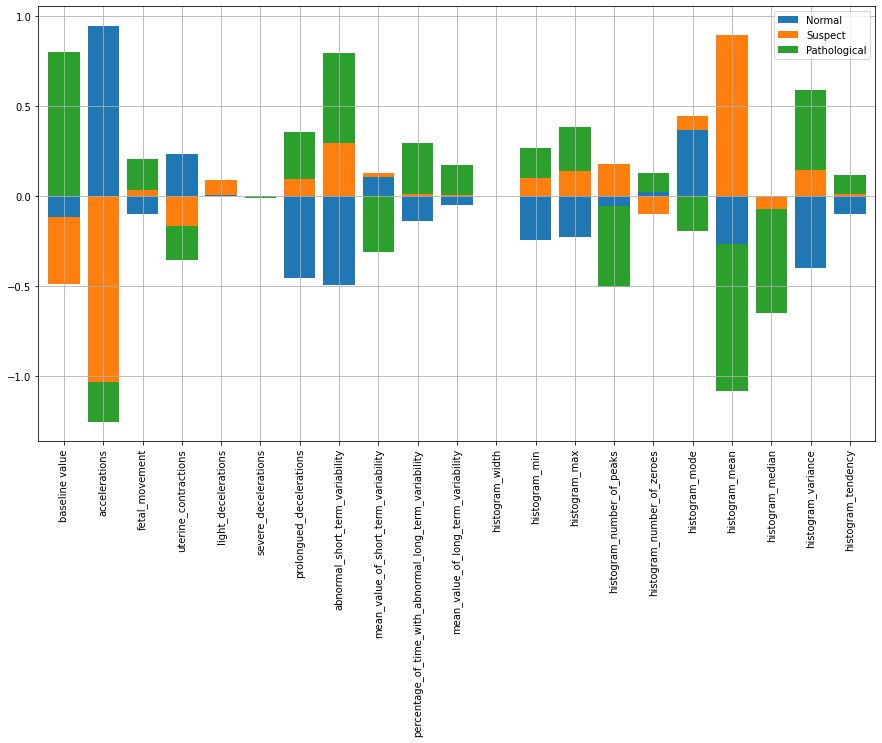

In [313]:
get_features_scores(svm)

In [314]:
print_eval(X_val, y_val, svm)

Score: 0.890         (89.00%)

Confusion Matrix: 
     1.0  2.0  3.0
1.0  533   22    5
2.0   29   61   14
3.0    4    4   37

f1_score per feature: 
[0.94671403 0.63874346 0.73267327]

f1_score macro: 0.773


### Alberi decisionali

In [271]:
from sklearn.tree import DecisionTreeClassifier

In [272]:
tree_model = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier())
])

In [273]:
params_grid = {
    "tree__max_depth": [2, 4, 6, 8, 10],
    "tree__min_samples_leaf": np.arange(1, 10),
    "tree__min_samples_split": np.arange(2, 20, 2)
}

In [274]:
tree, tree_best_params, tree_ranking = \
    get_tuned_model(tree_model, params_grid, X_train, y_train)

In [275]:
tree_best_params

{'tree__max_depth': 10,
 'tree__min_samples_leaf': 1,
 'tree__min_samples_split': 4}

In [276]:
tree_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__max_depth,param_tree__min_samples_leaf,param_tree__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
325,0.013743,0.000822,0.002759,0.000603,10,1,4,"{'tree__max_depth': 10, 'tree__min_samples_lea...",0.922535,0.940141,0.908127,0.908127,0.908127,0.917412,0.012661,1
345,0.014402,0.002154,0.002993,0.000375,10,3,8,"{'tree__max_depth': 10, 'tree__min_samples_lea...",0.922535,0.915493,0.911661,0.922261,0.901060,0.914602,0.007930,2
342,0.012798,0.000617,0.002697,0.000143,10,3,2,"{'tree__max_depth': 10, 'tree__min_samples_lea...",0.919014,0.911972,0.911661,0.932862,0.893993,0.913900,0.012576,3
250,0.011691,0.000114,0.002419,0.000133,8,1,16,"{'tree__max_depth': 8, 'tree__min_samples_leaf...",0.915493,0.915493,0.922261,0.911661,0.904594,0.913900,0.005773,3
244,0.018034,0.000296,0.004461,0.000101,8,1,4,"{'tree__max_depth': 8, 'tree__min_samples_leaf...",0.922535,0.922535,0.922261,0.901060,0.901060,0.913890,0.010476,5


La funzione `get_features_scores(tree)` non funziona :(

In [277]:
print_eval(X_val, y_val, tree)

Score: 0.929         (92.95%)

Confusion Matrix: 
     1.0  2.0  3.0
1.0  535   20    5
2.0   21   82    1
3.0    3    0   42

f1_score per feature: 
[0.9562109  0.7961165  0.90322581]

f1_score macro: 0.885


## Confronto

In [278]:
from sklearn.metrics import classification_report
print(classification_report(y_val, perceptron.predict(X_val)))
print(classification_report(y_val, logistic.predict(X_val)))
print(classification_report(y_val, tree.predict(X_val)))

              precision    recall  f1-score   support

         1.0       0.96      0.92      0.94       560
         2.0       0.62      0.72      0.67       104
         3.0       0.69      0.80      0.74        45

    accuracy                           0.88       709
   macro avg       0.76      0.81      0.78       709
weighted avg       0.89      0.88      0.89       709

              precision    recall  f1-score   support

         1.0       0.94      0.95      0.95       560
         2.0       0.72      0.65      0.69       104
         3.0       0.76      0.82      0.79        45

    accuracy                           0.90       709
   macro avg       0.81      0.81      0.81       709
weighted avg       0.90      0.90      0.90       709

              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       560
         2.0       0.80      0.79      0.80       104
         3.0       0.88      0.93      0.90        45

    accuracy        